# GradientBoosting with Laplacian Loss 

In [1]:
import ctypes
from numpy.ctypeslib import ndpointer

In [2]:
!cc -fPIC -shared -o _fast_predict.so _predict.c

In [3]:
lib = ctypes.cdll.LoadLibrary('./_fast_predict.so')
fast_predict = lib.__new_predict
fast_predict.argtypes = [
    ndpointer(ctypes.c_float, flags='C_CONTIGUOUS'),\
    ctypes.c_int,\
    ctypes.c_int,\
    ndpointer(ctypes.c_int, flags='C_CONTIGUOUS'),\
    ndpointer(ctypes.c_int, flags='C_CONTIGUOUS'),\
    ndpointer(ctypes.c_float, flags='C_CONTIGUOUS'),\
    ndpointer(ctypes.c_float, flags='C_CONTIGUOUS'),\
    ndpointer(ctypes.c_float, flags='C_CONTIGUOUS'),\
    ndpointer(ctypes.c_int, flags='C_CONTIGUOUS')]
fast_predict.restype = ctypes.c_int

In [4]:
import numpy as np
from math import ceil
from scipy.optimize import minimize_scalar


class MyDecisionTreeRegressor:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=None, criterion='mse'):
        self.tree = dict()        
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        self.feature_importances_ = None
        self.imp = None
        self.min_samples_leaf = 1

    def __sort_samples(self, x, y):
        sorted_idx = x.argsort(axis=0)
        return x[sorted_idx], y[sorted_idx]
    
    def __div_samples(self, x, y, feature_id, threshold):
        left_mask = (x[:, feature_id] <= threshold)
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]
    
    def __find_threshold(self, x, y, node_id):
        x_sorted, y_sorted = self.__sort_samples(x, y)
        x_sorted = np.append(x_sorted, np.nan)
        if x_sorted.shape[0] == 0:
            return None, None 
   
        same_x_sizes = np.where(x_sorted[:-1] != x_sorted[1:])[0]
        x_sorted_un = x_sorted[same_x_sizes]
        if x_sorted_un.shape[0] == 1:
            return np.inf, None 
        partition_sizes = same_x_sizes + 1
        
        left_y_sum = np.cumsum(y_sorted)
        right_y_sum = left_y_sum[-1] - left_y_sum

        left_y_sq_sum = np.cumsum(y_sorted ** 2)
        right_y_sq_sum = left_y_sq_sum[-1] - left_y_sq_sum
        
        left_y_sum = left_y_sum[partition_sizes - 1]
        right_y_sum = right_y_sum[partition_sizes - 1]
        left_y_sq_sum = left_y_sq_sum[partition_sizes - 1]
        right_y_sq_sum = right_y_sq_sum[partition_sizes - 1]
        
        sizes_left = partition_sizes
        sizes_right = y_sorted.shape[0] - sizes_left

        sizes_right[-1] = 1 # to prevent zero division
        
        var_left = left_y_sq_sum - left_y_sum ** 2 / sizes_left
        var_right = right_y_sq_sum - right_y_sum ** 2 / sizes_right
        
        var_sum = var_left + var_right
        
        var_argmin = np.argmin(var_sum)
        if var_argmin != (var_sum.shape[0] - 1):
            return var_sum[var_argmin], (x_sorted_un[var_argmin + 1] + x_sorted_un[var_argmin]) / 2.
        return var_sum[var_argmin], None
    
    def __fit_node(self, x, y, node_id, depth):
        if (x.shape[0] < self.min_samples_split) or (depth == self.max_depth):
            # is_leaf, feature_ids, threshold, ans
            self.tree[node_id] = (self.LEAF_TYPE, -1, -1, np.mean(y)) 
            return
        indices = np.arange(x.shape[1])
        thresholds = np.array([self.__find_threshold(x[:, idx], y, node_id) for idx in indices])
        feature_id = np.argmin(thresholds[:, 0])
        
        optimal_threshold = thresholds[feature_id, 1]
        
        if optimal_threshold is None:
            self.tree[node_id] = (self.LEAF_TYPE, -1, -1, np.mean(y)) 
            return
    
        x_l, x_r, y_l, y_r = self.__div_samples(x, y, feature_id, optimal_threshold)
        
        if x_l.shape[0] < self.min_samples_leaf or x_r.shape[0] < self.min_samples_leaf:
            self.tree[node_id] = (self.LEAF_TYPE, -1, -1, np.mean(y)) 
            return
        
        self.tree[node_id] = (self.NON_LEAF_TYPE, feature_id, optimal_threshold, -1)
    
        self.__fit_node(x_l, y_l, 2 * node_id + 1, depth + 1)
        self.__fit_node(x_r, y_r, 2 * node_id + 2, depth + 1)
        
    def fit(self, x, y):
        self.__fit_node(x, y, 0, 0)
        
        self.is_leafs = self.to_list(self.tree, 0)
        self.feature_ids = self.to_list(self.tree, 1)
        self.thresholds = self.to_list(self.tree, 2)
        self.answers_in_leaf = self.to_list(self.tree, 3)
        return
    
    def __old_predict(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold, _ = node
            if x[feature_id] <= threshold:
                return self.__predict(x, 2 * node_id + 1)
            else:
                return self.__predict(x, 2 * node_id + 2)
        else:
            return node[-1]
    
    def old_predict(self, X):
        return np.array([self.__old_predict(x, 0) for x in X])
    
    def __fast_predict(self, X):
        predictions = np.zeros(X.shape[0], dtype=np.float32)
        leaf_indices = np.zeros(X.shape[0], dtype=np.int32)
        fast_predict(X.astype(np.float32),
                     X.shape[0], 
                     X.shape[1], 
                     np.array(self.is_leafs,dtype=np.int32),
                     np.array(self.feature_ids, dtype=np.int32), 
                     np.array(self.thresholds,dtype=np.float32),
                     np.array(self.answers_in_leaf, dtype=np.float32),
                     predictions, 
                     leaf_indices)
        return predictions, leaf_indices
    
    def predict(self, X):
        return self.__fast_predict(X)[0]
    
    def get_leaf_indices(self, X):
        return self.__fast_predict(X)[1]
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def to_list(self, t_dict, column_ind):
        res = [t_dict[k][column_ind] if k in t_dict.keys() else 0 for k in range(max(t_dict.keys()) + 1)]
        return res

In [5]:
import numpy as np
from tqdm import tqdm

class MyGradientBoostingRegressor:
    def __init__(self, n_estimators, learning_rate=0.1, max_depth=5):
        """
        n_estimators : int
            The number of trees in the forest.
        
        learning_rate : float

        max_depth : int
            The maximum depth of the tree. If None then there is no limits.
        
        """
        self.n_estimators = n_estimators
        self.lr = learning_rate
        self.max_depth = max_depth
        
    def _MAE(self, y, z):
        return np.abs(y - z).mean()
    
    def loss_negative_gradient(self, y, z):
        return 2 * (y - z > 0) - 1
    
    def update_term_regions(self, mdl, X, y, answers):
        # leaf_ids.shape = X.shape[0]
        # leaf_ids[k] - number from 0 to (2 * max_depth - 1) if max_depth is set
        leaf_ids = mdl.get_leaf_indices(X)
        # indices of X_train respect to the leaf they are related to
        x_indices = np.argsort(leaf_ids)
        
        leaf_ids_sorted = leaf_ids[x_indices]
        stacked_groups = np.concatenate((leaf_ids_sorted[:, np.newaxis], x_indices[:, np.newaxis]), axis=1)
        groups = np.split(stacked_groups[:, 1], np.cumsum(np.unique(stacked_groups[:, 0], 
                                                                    return_counts=True)[1])[:-1])
        # TODO - probably can be changed to list(range(0,leaf_ids.max()))
        leaf_ids_un = np.unique(leaf_ids_sorted).astype(np.int32)
            
        for j, group in enumerate(groups):
            # groups of values in certain leaf in mdl
            group_int = group.astype(np.int32)
            mdl.answers_in_leaf = np.array(mdl.answers_in_leaf)
            mdl.answers_in_leaf[leaf_ids_un[j]] = np.median(y[group_int] - answers[group_int])
        return
            
    def fit(self, X, y):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
            
        y : numpy ndarray
            Array of size n_objects
        """
        self.tree_list = []
        
        self.med = np.median(y)
        
        answers = np.empty(X.shape[0])
        answers.fill(self.med)  # like dummy regressor
        
        for i in tqdm(range(self.n_estimators)):
            mdl = MyDecisionTreeRegressor(max_depth=self.max_depth)
            mdl.fit(X, self.loss_negative_gradient(y, answers))
            self.update_term_regions(mdl, X, y, answers)
            current_predict = mdl.predict(X)
            self.tree_list.append(mdl)
            answers += self.lr * current_predict

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
            
        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        result = self.med
        for i in range(self.n_estimators):
            result += self.lr * self.tree_list[i].predict(X)
        return result
    
    def staged_predict(self, X, step_size):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
            
        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        result = self.med
        for i in range(self.n_estimators):
            result += self.lr * self.tree_list[i].predict(X)
            if i % step_size == 0:
                yield result.copy()

In [6]:
with open("Regression dataset/reg.train.txt") as f:
    data = []
    label = [] 
    for row in f:
        splitted_row = row.split()
        label.append(float(splitted_row[0]))
        features = np.array([np.nan]*245)
        for current_row in splitted_row[1:-1]:
            feature_id, feature_value = current_row.split(':')
            feature_id, feature_value = int(feature_id), float(feature_value)
            features[feature_id] = feature_value
        data.append(features[1:])

X_train = np.array(data)
y_train = np.array(label)

with open("Regression dataset/reg.test.txt") as f:
    data = []
    label = [] 
    for row in f:
        splitted_row = row.split()
        label.append(float(splitted_row[0]))
        features = np.array([np.nan]*245)
        for current_row in splitted_row[1:-1]:
            feature_id, feature_value = current_row.split(':')
            feature_id, feature_value = int(feature_id), float(feature_value)
            features[feature_id] = feature_value
        data.append(features[1:])

X_test = np.array(data)
y_test = np.array(label)

In [7]:
from sklearn.impute import SimpleImputer

inp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_train = inp_median.fit_transform(X_train)
inp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_test = inp_median.fit_transform(X_test)

In [8]:
X_train = X_train.copy('C')
X_test = X_test.copy('C')

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error


x_train = X_train
x_test = X_test
print("train_x size {}, train_y size {}".format(x_train.shape, y_train.shape))
print("test_x size {}, test_y size {}".format(x_test.shape, y_test.shape))

train_x size (7200, 243), train_y size (7200,)
test_x size (10050, 243), test_y size (10050,)


In [10]:
%%time
my_regr = MyDecisionTreeRegressor(max_depth=3)
new_tree_t = my_regr.fit(x_train, y_train)

CPU times: user 337 ms, sys: 105 µs, total: 338 ms
Wall time: 336 ms


In [11]:
%%time
their_regr = DecisionTreeRegressor(max_depth=3)
their_regr.fit(x_train, y_train)

CPU times: user 171 ms, sys: 3.74 ms, total: 175 ms
Wall time: 173 ms


DecisionTreeRegressor(max_depth=3)

In [12]:
%%time
mean_absolute_error(my_regr.predict(x_train), y_train), mean_absolute_error(my_regr.predict(x_test), y_test)

CPU times: user 10.1 ms, sys: 3.9 ms, total: 14 ms
Wall time: 12.1 ms


(0.653377730266279, 0.7438600515407738)

In [13]:
%%time
mean_absolute_error(their_regr.predict(x_train), y_train), mean_absolute_error(their_regr.predict(x_test), y_test)

CPU times: user 11.9 ms, sys: 3.57 ms, total: 15.4 ms
Wall time: 13.7 ms


(0.6533777249291676, 0.743860048682748)

In [14]:
%%time
my_gb = MyGradientBoostingRegressor(max_depth=3, n_estimators=50)
my_gb.fit(x_train, y_train)

100%|██████████| 50/50 [00:17<00:00,  2.85it/s]

CPU times: user 17.6 s, sys: 16.4 ms, total: 17.6 s
Wall time: 17.6 s


In [15]:
%%time
sk_gb = GradientBoostingRegressor(max_depth=3, n_estimators=50, loss='lad', criterion='mse')
sk_gb.fit(x_train, y_train)

CPU times: user 8.88 s, sys: 4 ms, total: 8.88 s
Wall time: 8.89 s


GradientBoostingRegressor(criterion='mse', loss='lad', n_estimators=50)

In [16]:
%%time
mean_absolute_error(my_gb.predict(x_train), y_train), mean_absolute_error(my_gb.predict(x_test), y_test)

CPU times: user 530 ms, sys: 3.98 ms, total: 534 ms
Wall time: 541 ms


(0.6323654533779318, 0.7536054123986149)

In [17]:
%%time
mean_absolute_error(sk_gb.predict(x_train), y_train), mean_absolute_error(sk_gb.predict(x_test), y_test)

CPU times: user 74.9 ms, sys: 11 µs, total: 74.9 ms
Wall time: 73 ms


(0.617161358806159, 0.7540259298858236)

### Графики

In [18]:
def compare_boosters(max_depth, max_n_trees, n_est_step):
    my_loss_train = []
    my_loss_test = []
    their_loss_train = []
    their_loss_test = []

    step_size = n_est_step
    
    my_booster = MyGradientBoostingRegressor(n_estimators=max_n_trees, max_depth=max_depth)
    my_booster.fit(x_train, y_train)

    for my_pred in my_booster.staged_predict(x_train, step_size=step_size):
        my_loss_train.append(mean_absolute_error(my_pred, y_train))

    for my_pred in my_booster.staged_predict(x_test, step_size=step_size):
        my_loss_test.append(mean_absolute_error(my_pred, y_test))
    
    print('MyGradientBoostingRegressor.fit() finished')
    print('Fitting Sklearn.GradientBoostingRegressor...')
    
    their_booster = GradientBoostingRegressor(n_estimators=max_n_trees, max_depth=max_depth,
                                              loss='lad', criterion='mse', random_state=1337)
    their_booster.fit(x_train, y_train)

    for their_pred in list(their_booster.staged_predict(x_train))[::step_size]:
        their_loss_train.append(mean_absolute_error(their_pred, y_train))

    for their_pred in list(their_booster.staged_predict(x_test))[::step_size]:
        their_loss_test.append(mean_absolute_error(their_pred, y_test))
        
    plt.figure(figsize=(16,10))
    n_trees = np.arange(1, max_n_trees, step_size)
    their_loss_test = np.array(their_loss_test)
    ax = plt.subplot(1,2,1)
    ax.plot(n_trees, my_loss_test, label='my')
    ax.plot(n_trees, their_loss_test, label='sklearn', linestyle='dashdot')
    down = their_loss_test * (1 - 0.03)
    upper = their_loss_test * (1 + 0.03)
    ax.plot(n_trees, down, label='sklearn 3% down', color='red')
    ax.plot(n_trees, upper, label='sklearn 3% upper', color='red')
    ax.fill_between(n_trees, down, upper, color='b', alpha=0.1)
    plt.xlabel('n_estimators', fontsize=12)
    plt.ylabel('MAE on TEST', fontsize=12)
    plt.title('TEST', fontsize=15)
    plt.legend(fontsize=12)

    their_loss_train = np.array(their_loss_train)
    ax = plt.subplot(1,2,2)
    ax.plot(n_trees, my_loss_train, label='my')
    ax.plot(n_trees, their_loss_train, label='sklearn', linestyle='dashdot')
    down = their_loss_train * (1 - 0.03)
    upper = their_loss_train * (1 + 0.03)
    ax.plot(n_trees, down, label='sklearn 3% down', color='red')
    ax.plot(n_trees, upper, label='sklearn 3% upper', color='red')
    ax.fill_between(n_trees, down, upper, color='b', alpha=0.1)
    plt.xlabel('n_estimators', fontsize=12)
    plt.ylabel('MAE on TRAIN', fontsize=12)
    plt.title('TRAIN', fontsize=15)
    plt.legend(fontsize=12)
    plt.show()
    return my_loss_train, my_loss_test, their_loss_train, their_loss_test

100%|██████████| 2000/2000 [10:24<00:00,  3.20it/s]


MyGradientBoostingRegressor.fit() finished
Fitting Sklearn.GradientBoostingRegressor...


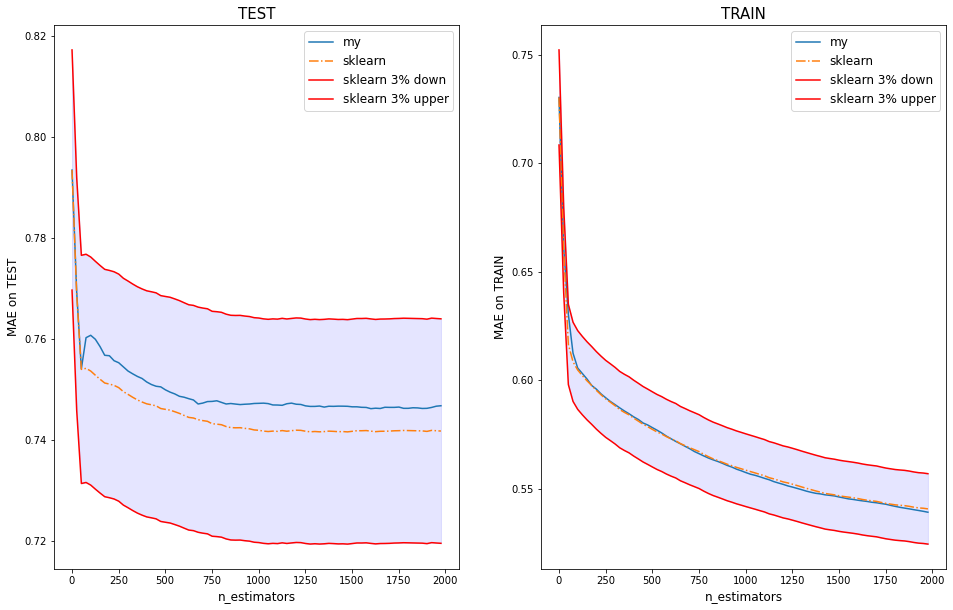

In [24]:
m_tr, m_tt, sk_tr, sk_tt = compare_boosters(max_depth=3, max_n_trees=2000, n_est_step=25)

100%|██████████| 2000/2000 [19:09<00:00,  1.74it/s]


MyGradientBoostingRegressor.fit() finished
Fitting Sklearn.GradientBoostingRegressor...


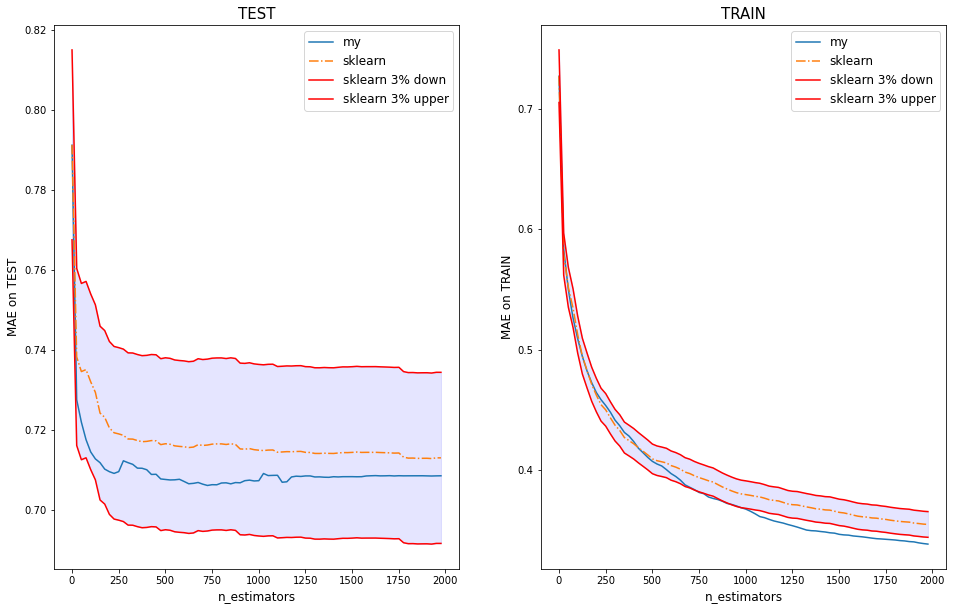

In [25]:
m_tr, m_tt, sk_tr, sk_tt = compare_boosters(max_depth=5, max_n_trees=2000, n_est_step=25)

100%|██████████| 2000/2000 [27:39<00:00,  1.21it/s]


MyGradientBoostingRegressor.fit() finished
Fitting Sklearn.GradientBoostingRegressor...


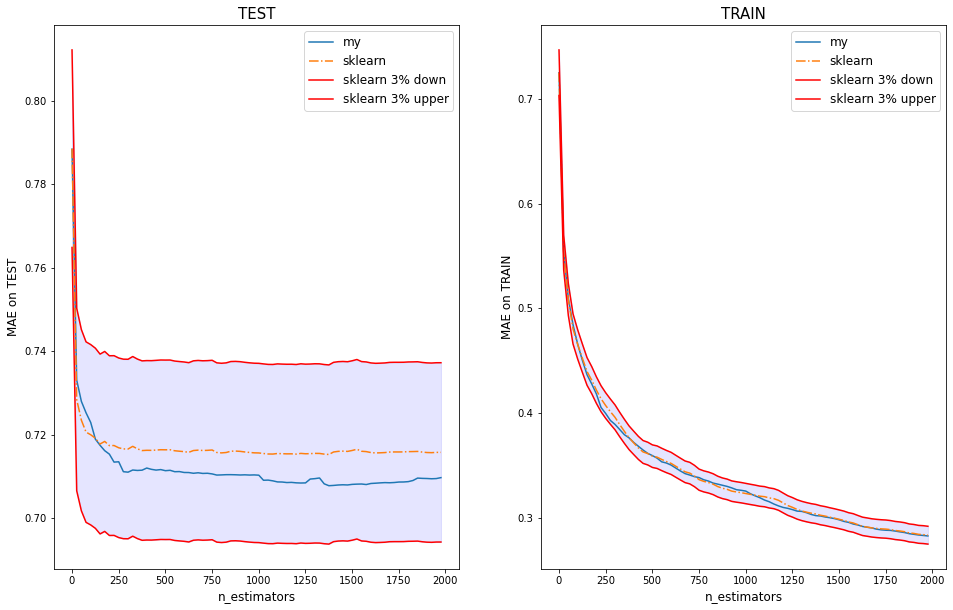

In [26]:
m_tr, m_tt, sk_tr, sk_tt = compare_boosters(max_depth=6, max_n_trees=2000, n_est_step=25)

100%|██████████| 2000/2000 [32:55<00:00,  1.01it/s]


MyGradientBoostingRegressor.fit() finished
Fitting Sklearn.GradientBoostingRegressor...


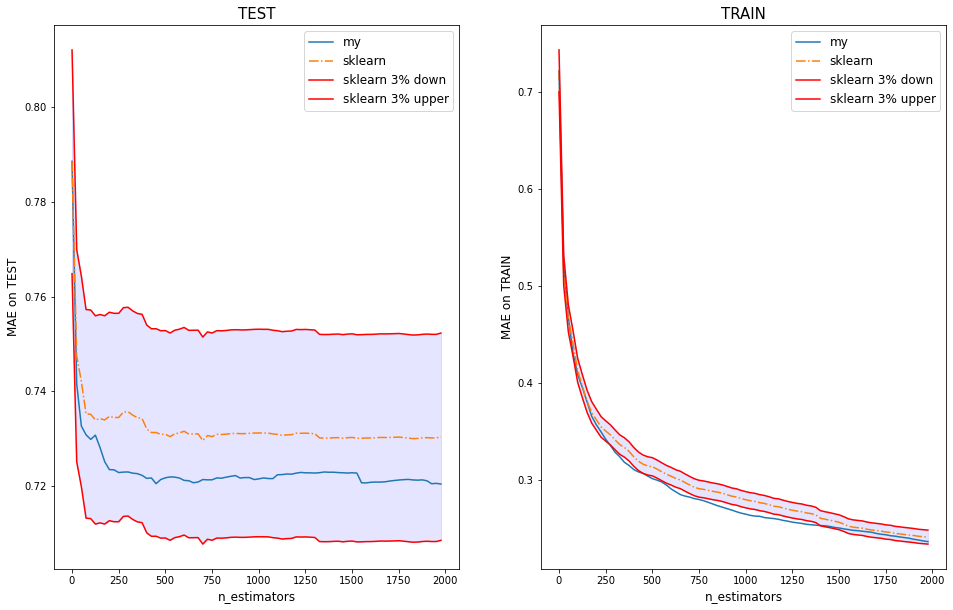

In [27]:
m_tr, m_tt, sk_tr, sk_tt = compare_boosters(max_depth=7, max_n_trees=2000, n_est_step=25)